# Pneumonia detection

## Introduction

Pneumonia is a common respiratory infection that affects millions of people worldwide, leading to significant morbidity and mortality. Accurate and timely diagnosis is essential for effective treatment and management of pneumonia. In recent years, deep learning techniques, particularly convolutional neural networks (CNNs), have shown great promise in medical image analysis, including the diagnosis of pneumonia through the analysis of chest X-ray images.

The goal of this project is to build a deep learning model to classify chest X-ray images into two categories: normal and pneumonia. We will use a dataset of chest X-ray images, preprocess the data, perform data augmentation, and train a convolutional neural network to classify the images. Finally, we will evaluate the model's performance on a test set and discuss the results. This project aims to demonstrate the potential of deep learning in medical image analysis and contribute to improving the diagnosis of pneumonia.




## Import Libraries

In [1]:
# PyTorch modules
import torch
from torch import nn
from torch.utils.data import ConcatDataset, DataLoader, random_split

# Data splitting and shuffling modules
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torch.utils.data import Subset

# Image processing modules
from PIL import Image
from torchvision import transforms as transform
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image

# File and directory handling modules
import os
from pathlib import Path
import shutil

# Progress bar and timing modules
from timeit import default_timer as timer
from tqdm.auto import tqdm

# Visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

# Other modules
import numpy as np
import requests
import zipfile


## Loading and Preprocessing Data

### Load images from GitHub repository

In [2]:
# Setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'chest_xray'

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f'{image_path} directory already exists... skipping download')
else: 
  print(f'{image_path} does not exist, creating one...')
  image_path.mkdir(parents=True, exist_ok=True)

# Download x-ray scans data
with open(data_path / 'chest_xray.zip', 'wb') as f:
  request = requests.get('https://github.com/eliaszpiotr/PneumoniaDetection/raw/main/data/chest_xray.zip')
  print('Downloading data...')
  f.write(request.content)

# Unzip data
with zipfile.ZipFile(data_path / 'chest_xray.zip', 'r') as zip_ref:
  print('Unzipping data...')
  zip_ref.extractall(image_path)

data/chest_xray does not exist, creating one...
Unzipping data...


### Seting up paths

In [3]:
# Define paths to dataset folders
train_dir = image_path / 'chest_xray/train'
test_dir = image_path / 'chest_xray/test'
val_dir = image_path / 'chest_xray/val'

train_dir, test_dir, val_dir

(PosixPath('data/chest_xray/chest_xray/train'),
 PosixPath('data/chest_xray/chest_xray/test'),
 PosixPath('data/chest_xray/chest_xray/val'))

In [4]:
pneumonia_train_dir = train_dir / 'PNEUMONIA'
normal_train_dir = train_dir/ 'NORMAL'
pneumonia_test_dir = test_dir/ 'PNEUMONIA'
normal_test_dir = test_dir/ 'NORMAL'
pneumonia_val_dir = val_dir / 'PNEUMONIA'
normal_val_dir = val_dir/ 'NORMAL'

In [5]:
# Print out som info about data
print("Number of images in the training set:")
print("Pneumonia: ", len(os.listdir(pneumonia_train_dir)))
print("Normal: ", len(os.listdir(normal_train_dir)), '\n')

print("Number of images in the test set:")
print("Pneumonia: ", len(os.listdir(pneumonia_test_dir)))
print("Normal: ", len(os.listdir(normal_test_dir)), '\n')


print("Number of images in the validation set:")
print("Pneumonia: ", len(os.listdir(pneumonia_val_dir)))
print("Normal: ", len(os.listdir(normal_val_dir)), '\n')


Number of images in the training set:
Pneumonia:  3876
Normal:  1342 

Number of images in the test set:
Pneumonia:  390
Normal:  234 

Number of images in the validation set:
Pneumonia:  9
Normal:  9 



**Note:** Data is imbalanced, so we're gonna try to fix it by adding transformed samples .

### Data imbalance fixing

#### Setup transformers

In [6]:
transformer = {
    'dataset1': transform.Compose([
        transform.Resize(255),
        transform.CenterCrop(224),
        transform.RandomHorizontalFlip(),
        transform.RandomRotation(10),
        transform.Grayscale(num_output_channels=1),
        transform.RandomAffine(translate=(0.05, 0.05), degrees=0),
        transform.ToTensor(),
    ]),
    'dataset2': transform.Compose([
        transform.Resize(255),
        transform.CenterCrop(224),
        transform.RandomHorizontalFlip(p=1),
        transform.Grayscale(num_output_channels=1),
        transform.RandomAffine(translate=(0.1, 0.05), degrees=10),
        transform.ToTensor(),
    ]),
    'dataset3': transform.Compose([
        transform.Resize(255),
        transform.CenterCrop(224),
        transform.RandomHorizontalFlip(p=0.5),
        transform.RandomRotation(15),
        transform.Grayscale(num_output_channels=1),
        transform.RandomAffine(translate=(0.08, 0.1), degrees=15),
        transform.ToTensor(),
    ]),
}


#### Data Augmentation

In [7]:
def apply_transforms_and_save(input_dir, output_dir, transform):
    for img_name in os.listdir(input_dir):
        # Skip the file if it is not an image
        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            continue

        img_path = input_dir / img_name
        img = Image.open(img_path)
        transformed_img = transform(img)
        # Add the 'aug_' prefix to the filename to distinguish the augmented images from the original ones
        save_path = output_dir / f"aug_{img_name}"
        save_image(transformed_img, save_path)

apply_transforms_and_save(normal_train_dir, normal_train_dir, transformer['dataset1'])
apply_transforms_and_save(normal_train_dir, normal_train_dir, transformer['dataset2'])
apply_transforms_and_save(normal_train_dir, normal_train_dir, transformer['dataset3'])



### Create Datasets

In [8]:
# Setup datasets
train_dataset = ImageFolder(train_dir,transform=transform.Compose([
    transform.Resize(255),
    transform.CenterCrop(224),
    transform.Grayscale(num_output_channels=1),
    transform.ToTensor(),
]))

test_dataset = ImageFolder(test_dir, transform=transform.Compose([
    transform.Resize(255),
    transform.CenterCrop(224),
    transform.Grayscale(num_output_channels=1),
    transform.ToTensor(),
]))

val_dataset = ImageFolder(val_dir, transform=transform.Compose([
    transform.Resize(255),
    transform.CenterCrop(224),
    transform.Grayscale(num_output_channels=1),
    transform.ToTensor(),
]))


In [9]:
# Printing out info about data after adding samples
print("New number of images in the training set:")
print("Pneumonia: ", len(os.listdir(pneumonia_train_dir)))
print("Normal: ", len(os.listdir(normal_train_dir)), '\n')

New number of images in the training set:
Pneumonia:  3876
Normal:  5365 



### Preparing data splits

In [10]:
# Load the original training data set
train_val_dataset = ImageFolder(train_dir, transform=transform.Compose([
    transform.Resize(255),
    transform.CenterCrop(224),
    transform.Grayscale(num_output_channels=1),
    transform.ToTensor(),
]))

# Split your training dataset into new training and validation sets
train_indices, val_indices = train_test_split(
    range(len(train_val_dataset)),
    test_size=0.2,  # 20% of the data will be used as validation
    random_state=42,  # Set a random state to make the split deterministic
    stratify=train_val_dataset.targets
)

train_dataset = Subset(train_val_dataset, train_indices)
val_dataset = Subset(train_val_dataset, val_indices)


In [11]:
# Get list of class names
class_names = train_val_dataset.classes
class_names

['NORMAL', 'PNEUMONIA']

### Create DataLoaders

In [12]:
# Parameters to set DataLoaders
batch_size = 32
num_workers = os.cpu_count()

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


### Data visualization

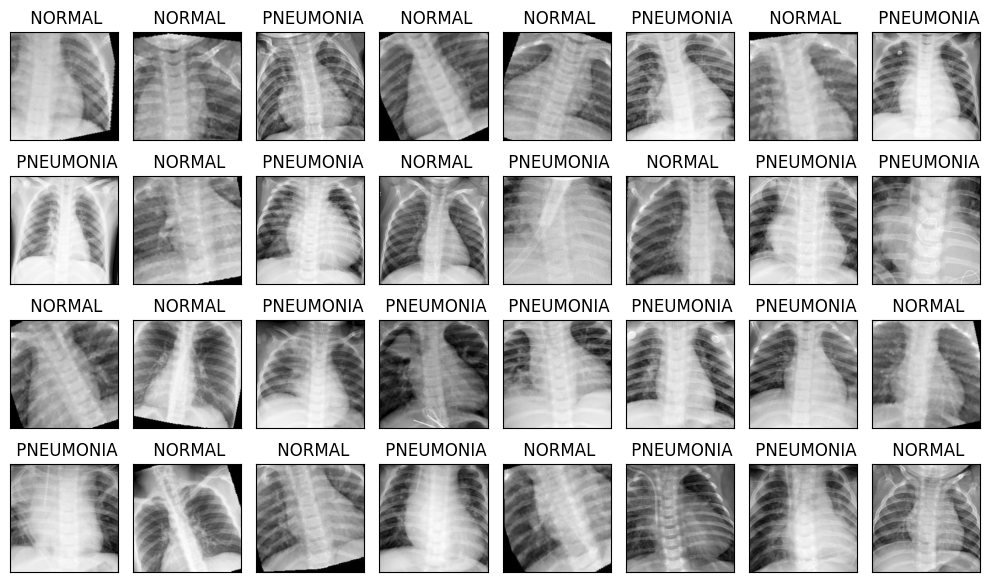

In [13]:
# Print sample images and labels from train_loader
for images, labels in train_loader:
    # Select the first batch from train_loader
    break

# Print out sample images
fig, axs = plt.subplots(4, 8, figsize=(10, 6), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i].squeeze().numpy(), cmap='gray')
    ax.set_title(f" {class_names[labels[i].item()]}")
plt.tight_layout()
plt.show()


## Define the Model

In [14]:
class PneumoniaClassifier(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((13, 13))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_2(self.conv_block_1(x))
        x = self.avgpool(x)
        return self.classifier(x)


In [15]:
# Create a model instance
input_channels = 1  # image input channels (RGB) - 1 as we have images in gray scale
hidden_units = 10  # number of units hidden in convolutional layers
model = PneumoniaClassifier(input_channels, hidden_units, 2)

## Training Preparation

### Setting up device-agnostic code

In [16]:
# Move the model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Setting up loss function and optimizer

In [17]:
# Setup optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

## Training

In [18]:
# Setup random seed
torch.manual_seed(42)

# Measure time
start_time = timer()

# Setup epochs
epochs = 10

# Create lists to store losses and accuracies
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()
    for images, labels in train_loader:
        # Move images and labels to GPU (if available)
        images = images.to(device)
        labels = labels.to(device)

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Compute training statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Evaluate the model on validation data
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.inference_mode():
        for images, labels in val_loader:
            # Move images and labels to GPU (if available)
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Compute validation statistics
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_dataset)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch+1} ----------\n'
          f'Training Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f} | Validation Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}')
    
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 ----------
Training Loss: 0.4311 | Accuracy: 0.7941 | Validation Loss: 0.2948 | Accuracy: 0.8907
Epoch 2 ----------
Training Loss: 0.2326 | Accuracy: 0.9099 | Validation Loss: 0.2472 | Accuracy: 0.9102
Epoch 3 ----------
Training Loss: 0.2082 | Accuracy: 0.9188 | Validation Loss: 0.2608 | Accuracy: 0.8983
Epoch 4 ----------
Training Loss: 0.1762 | Accuracy: 0.9318 | Validation Loss: 0.2105 | Accuracy: 0.9297
Epoch 5 ----------
Training Loss: 0.1684 | Accuracy: 0.9383 | Validation Loss: 0.1991 | Accuracy: 0.9361
Epoch 6 ----------
Training Loss: 0.1521 | Accuracy: 0.9436 | Validation Loss: 0.2353 | Accuracy: 0.9248
Epoch 7 ----------
Training Loss: 0.1435 | Accuracy: 0.9472 | Validation Loss: 0.1767 | Accuracy: 0.9416
Epoch 8 ----------
Training Loss: 0.1322 | Accuracy: 0.9540 | Validation Loss: 0.2171 | Accuracy: 0.9269
Epoch 9 ----------
Training Loss: 0.1261 | Accuracy: 0.9548 | Validation Loss: 0.1766 | Accuracy: 0.9443
Epoch 10 ----------
Training Loss: 0.1210 | Accuracy: 0

## Evaluation


### Test accuracy

In [19]:
def evaluate(model, test_loader, device):
    model.eval()

    correct = 0
    total = 0

    with torch.inference_mode():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy


In [20]:
test_accuracy = evaluate(model, test_loader, device)
print(f'Test Accuracy: {100*test_accuracy:.4f}%')


Test Accuracy: 78.6859%


### Loss curves

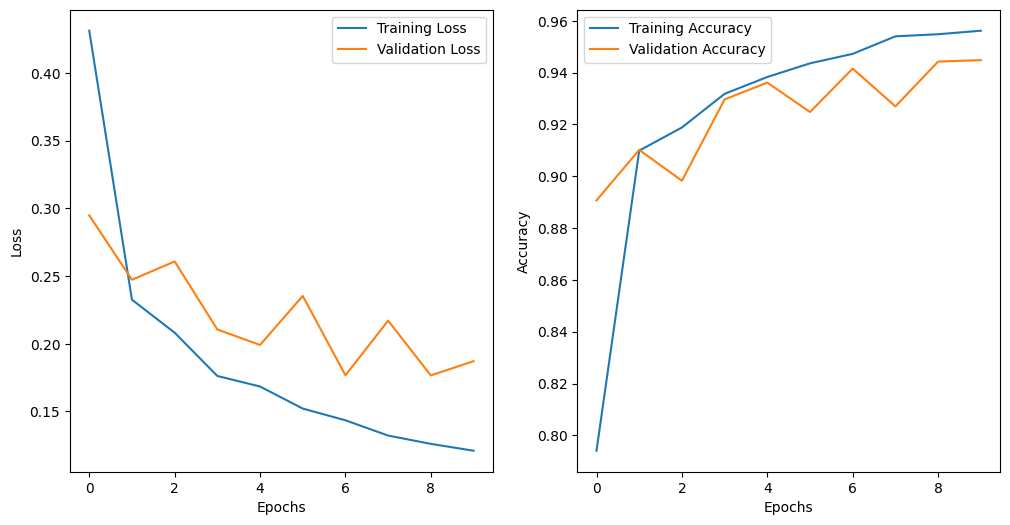

In [21]:
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Making predictions

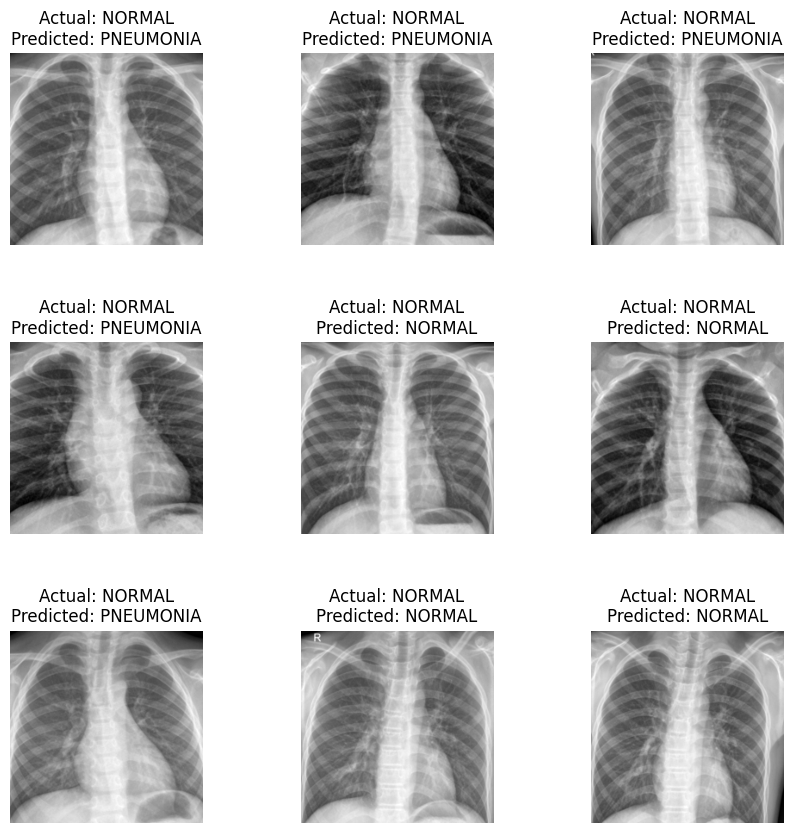

In [22]:
def display_image(image, title):
    image = image.numpy().transpose((1, 2, 0))
    image = image.squeeze()
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis(False)

num_samples = 9
rows, cols = 3, 3
model.eval()

with torch.inference_mode():
    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    sample_count = 0
    
    for images, labels in test_loader:
        if sample_count >= num_samples:
            break
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        for j in range(len(images)):
            if sample_count >= num_samples:
                break
            ax = axs[sample_count // cols, sample_count % cols]
            plt.sca(ax) # Set the current axes
            display_image(images[j].cpu(), f"Actual: {class_names[labels[j].item()]}\nPredicted: {class_names[predicted[j].item()]}")
            sample_count += 1

    plt.show()


### Confusion matrix

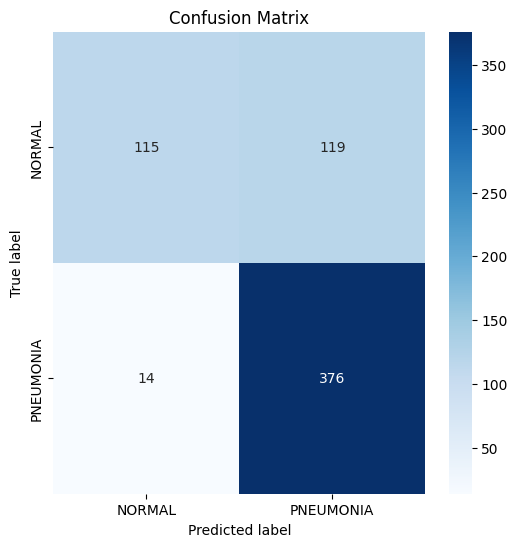

In [23]:
# Get true labels and predicted labels
y_true = []
y_pred = []

model.eval()
with torch.inference_mode():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

## Evaluation Summary

The evaluation of the model indicates that it performs reasonably well on both training and validation datasets. The loss curves and accuracy curves provide insight into how the model learns and generalizes to unseen data over the training epochs. It is important to monitor these curves to ensure that the model is not overfitting the training data, which would result in poor performance on the validation dataset.

There are several ways to potentially improve the model's accuracy:

1. **Data augmentation:** Increase the variety of training data by applying different transformations, such as rotations, translations, and flips. This can help the model learn more robust features, which could lead to better generalization.
2. **Model architecture:** Experiment with different model architectures, such as deeper or wider networks, to find a more suitable model for the task. Alternatively, consider using pre-trained models and fine-tuning them for your specific task.
3. **Hyperparameter tuning:** Optimize various hyperparameters, such as learning rate, batch size, and weight initialization, to find a better combination that can lead to improved model performance.
4. **Regularization techniques:** Apply techniques like dropout or weight decay to reduce overfitting and improve generalization.
5. **Training for more epochs:** Increase the number of training epochs, which could allow the model to learn more complex features and improve its performance on the task. 

However, be cautious not to overtrain the model, as this may lead to overfitting.
In conclusion, the model's performance can be improved by exploring different techniques and approaches. Carefully monitoring the loss and accuracy curves during training and validation will help identify areas for potential improvement and ensure the model generalizes well to new data.




## Saving and loading data

In [24]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)

# Save the model
save_model(model, "my_model.pth")


In [30]:
def load_model(model_class, filename, device='cpu', *args, **kwargs):
    model = model_class(*args, **kwargs)
    model.load_state_dict(torch.load(filename, map_location=device))
    model.eval()
    return model

# Load the model
loaded_model = load_model(PneumoniaClassifier, "my_model.pth", device, 1, 10, 2)
